# View Data
Sunday, 6th of March 2022

This notebook will build the code required to get up the dashboard in the *dashboard.py* file

### Connect to DB

In [22]:
# Database connection
import psycopg2
from psycopg2 import Error

def connect_to_postgres_database(user, password, database, host="127.0.0.1", port="5432"):
    """
    Function connects to a database and returns the cursor object
    :param user: database username
    :param password: database password
    :param database: database name
    :param host: server location
    :param port: listening port
    :return: psycopg2 cursor object
    """
    try:
        con = psycopg2.connect(user=user,
                               password=password,
                               database=database,
                               host=host,
                               port=port)
        cursor = con.cursor()
    except (Exception, Error) as error:
        print("Error while connecting to PostgreSQL", error)
    return con, cursor

In [23]:
USER = "postgres"
PASSWORD = "Barca2011"
DATABASE = "golf_dashboard_db"

con, cursor = connect_to_postgres_database(USER, PASSWORD, DATABASE, host="127.0.0.1", port="5432")

### SQLAlchemy Connector
We need to create a SQLAlchemy engine in order to query directly to Pandas DataFrame

In [24]:
from sqlalchemy import create_engine

USER = "postgres"
PASSWORD = "Barca2011"
DATABASE = "golf_dashboard_db"

engine = create_engine("postgresql+psycopg2://" + USER + ":" + PASSWORD + "@localhost/" + DATABASE)

### Rounds Played in a Country
This SQL function returns a table containing the country, alpha3, continent and times played in country for a specified user

In [25]:
import pandas as pd

user_id = 21
insert_command = """SELECT ac.country, ac.count, country_code.alpha3, country_code.continent
                    FROM country_code
                    JOIN (SELECT country, count(country)
                        FROM (SELECT course.name, course.country, round.course_id
                            FROM course
                            INNER JOIN round on course.course_id = round.course_id
                            WHERE course.user_id=%(user_id)s) AS ac
                    GROUP BY country) ac
                    ON country_code.country = ac.country;"""
played_in_country_df = pd.read_sql_query(insert_command, con=engine, params={"user_id": user_id})
played_in_country_df

,country,count,alpha3,continent
0,Spain,1,ESP,Europe
1,Thailand,2,THA,Asia


In [26]:
def make_rounds_played_in_country_df(user_id):
    """
    Function returns a dataframe containing the country, alpha3, continent and times played in country for a specified user
    :param user_id: id of user
    :return: dataframe with country, alpha3, continent and times played in country for a specified user
    """
    insert_command = """SELECT ac.country, ac.count, country_code.alpha3, country_code.continent
                    FROM country_code
                    JOIN (SELECT country, count(country)
                        FROM (SELECT course.name, course.country, round.course_id
                            FROM course
                            INNER JOIN round on course.course_id = round.course_id
                            WHERE course.user_id=%(user_id)s) AS ac
                    GROUP BY country) ac
                    ON country_code.country = ac.country;"""
    played_in_country_df = pd.read_sql_query(insert_command, con=engine, params={"user_id": user_id})
    return played_in_country_df

In [27]:
played_in_country_df = make_rounds_played_in_country_df(user_id)
played_in_country_df

,country,count,alpha3,continent
0,Spain,1,ESP,Europe
1,Thailand,2,THA,Asia


In [28]:
# World Map
import plotly.express as px

fig = px.scatter_geo(played_in_country_df, locations="alpha3", color="continent",
                     hover_name="country", size="count", projection="natural earth")
fig.show()

In [29]:
import plotly.express as px

def plot_rounds_played_world_map(rounds_played_country_df):
    """
    Function returns a plotly map object showing the countries a player has played in
    :param rounds_played_country_df: DataFrame containing country, alpha3, continent and times played in country for a specified user
    :return: scatter_geo object
    """
    fig = px.scatter_geo(rounds_played_country_df, locations="alpha3", color="continent",
                         hover_name="country", size="count", projection="natural earth")
    return fig

In [30]:
plot_rounds_played_world_map(played_in_country_df)

In [31]:
import plotly.express as px

def make_rounds_played_in_country_df(user_id):
    """
    Function returns a dataframe containing the country, alpha3, continent and times played in country for a specified user
    :param user_id: id of user
    :return: dataframe with country, alpha3, continent and times played in country for a specified user
    """
    insert_command = """SELECT ac.country, ac.count, country_code.alpha3, country_code.continent
                    FROM country_code
                    JOIN (SELECT country, count(country)
                        FROM (SELECT course.name, course.country, round.course_id
                            FROM course
                            INNER JOIN round on course.course_id = round.course_id
                            WHERE course.user_id=%(user_id)s) AS ac
                    GROUP BY country) ac
                    ON country_code.country = ac.country;"""
    played_in_country_df = pd.read_sql_query(insert_command, con=engine, params={"user_id": user_id})
    return played_in_country_df


def plot_rounds_played_world_map(rounds_played_country_df):
    """
    Function returns a plotly map object showing the countries a player has played in
    :param rounds_played_country_df: DataFrame containing country, alpha3, continent and times played in country for a specified user
    :return: scatter_geo object
    """
    fig = px.scatter_geo(rounds_played_country_df, locations="alpha3", color="continent",
                         hover_name="country", size="count", projection="natural earth")
    return fig


def pipeline_plot_rounds_played_world_map(user_id):
    """
    Function pipelines the functions required to return a plotly map object showing the countries a player has played in
    :param user_id: id of user
    :return: scatter_geo object
    """
    played_in_country_df = make_rounds_played_in_country_df(user_id)
    fig = plot_rounds_played_world_map(played_in_country_df)
    return fig

In [32]:
pipeline_plot_rounds_played_world_map(1)

### Rounds by Day - Calendar
This section will use the calplot library to display a calendar of the days a user has played a round

In [33]:
insert_command = """SELECT round_id, date_played
                    FROM round
                    WHERE user_id=%(user_id)s
                    GROUP BY round_id;"""
df = pd.read_sql_query(insert_command, con=engine, params={"user_id": user_id})
df

,round_id,date_played
0,56,2022-01-26
1,57,2022-01-11
2,59,2022-01-22


In [34]:
def make_rounds_date_played_df(user_id):
    """
    Function returns a dataframe containing the round id and the date that round was played
    :param user_id: id of user
    :return: dataframe with round id and the date that round was played
    """
    insert_command = """SELECT round_id, date_played
                    FROM round
                    WHERE user_id=%(user_id)s
                    GROUP BY round_id;"""
    rounds_date_played_df = pd.read_sql_query(insert_command, con=engine, params={"user_id": user_id})
    return rounds_date_played_df

In [36]:
# Make date_played series
df["date_played"] = pd.to_datetime(df["date_played"])
dms = df.groupby(df['date_played'].dt.to_period('D')).count()['round_id'].to_timestamp()
max_year = df['date_played'].dt.to_period('D').max().year
min_year = df['date_played'].dt.to_period('D').min().year
idx = pd.date_range(str(min_year) + '-1-1', str(max_year) + '-12-31')
dms.index = pd.DatetimeIndex(dms.index)
daily_adds = dms.reindex(idx, fill_value=0)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


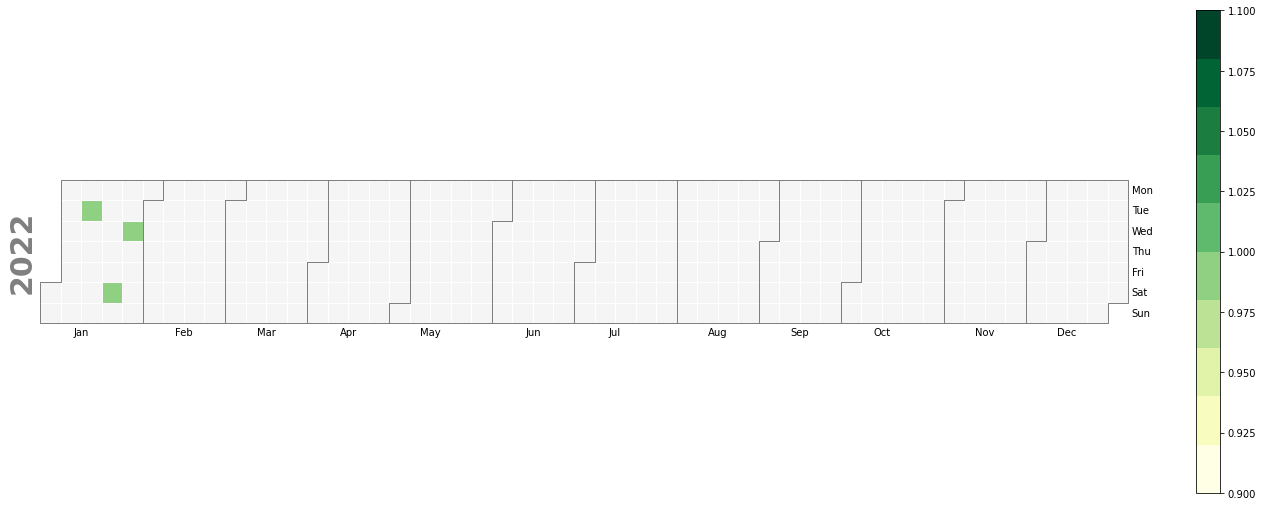

In [37]:
# Plot calendar
from pylab import *
cmap = cm.get_cmap('YlGn', 10)

import calplot
calplot.calplot(daily_adds, cmap = cmap, figsize = (20, 7))
plt.show()

In [38]:
def make_daily_rounds_date_played_series(rounds_date_played_df):
    """
    Function creates a series with index date and a column showing count of rounds played per date
    :param rounds_date_played_df: dataframe with round id and the date that round was played
    :return: series with index date and a column showing count of rounds played per date
    """
    rounds_date_played_df["date_played"] = pd.to_datetime(rounds_date_played_df["date_played"])
    dms = rounds_date_played_df.groupby(rounds_date_played_df['date_played'].dt.to_period('D')).count()['round_id'].to_timestamp()
    max_year = rounds_date_played_df['date_played'].dt.to_period('D').max().year
    min_year = rounds_date_played_df['date_played'].dt.to_period('D').min().year
    idx = pd.date_range(str(min_year) + '-1-1', str(max_year) + '-12-31')
    dms.index = pd.DatetimeIndex(dms.index)
    daily_rounds_date_played = dms.reindex(idx, fill_value=0)
    return daily_rounds_date_played

In [39]:
daily_rounds_date_played = make_daily_rounds_date_played_series(rounds_date_played_df)
daily_rounds_date_played

2022-01-01    0
2022-01-02    0
2022-01-03    0
2022-01-04    0
2022-01-05    0
             ..
2022-12-27    0
2022-12-28    0
2022-12-29    0
2022-12-30    0
2022-12-31    0
Freq: D, Name: round_id, Length: 365, dtype: int64

In [40]:
def plot_rounds_date_played_calendar(daily_rounds_date_played):
    """
    Function uses the calplot library to plot a calendar containing dates rounds were played
    :param daily_rounds_date_played: series with index date and a column showing count of rounds played per date
    :return: None
    """
    cmap = cm.get_cmap("Greens", 10)
    fig, ax = calplot.calplot(daily_rounds_date_played, cmap = cmap)
    return None

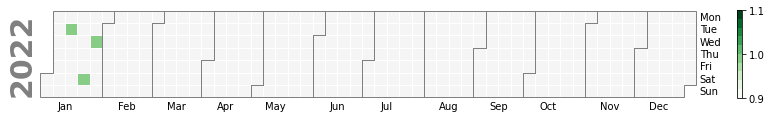

In [41]:
plot_rounds_date_played_calendar(daily_rounds_date_played)

In [42]:
from pylab import *
import calplot


def make_sql_rounds_date_played_df(user_id):
    """
    Function returns a dataframe containing the round id and the date that round was played
    :param user_id: id of user
    :return: dataframe with round id and the date that round was played
    """
    insert_command = """SELECT round_id, date_played
                    FROM round
                    WHERE user_id=%(user_id)s
                    GROUP BY round_id;"""
    rounds_date_played_df = pd.read_sql_query(insert_command, con=engine, params={"user_id": user_id})
    return rounds_date_played_df


def make_daily_rounds_date_played_series(rounds_date_played_df):
    """
    Function creates a series with index date and a column showing count of rounds played per date
    :param rounds_date_played_df: dataframe with round id and the date that round was played
    :return: series with index date and a column showing count of rounds played per date
    """
    rounds_date_played_df["date_played"] = pd.to_datetime(rounds_date_played_df["date_played"])
    dms = rounds_date_played_df.groupby(rounds_date_played_df['date_played'].dt.to_period('D')).count()['round_id'].to_timestamp()
    max_year = rounds_date_played_df['date_played'].dt.to_period('D').max().year
    min_year = rounds_date_played_df['date_played'].dt.to_period('D').min().year
    idx = pd.date_range(str(min_year) + '-1-1', str(max_year) + '-12-31')
    dms.index = pd.DatetimeIndex(dms.index)
    daily_rounds_date_played = dms.reindex(idx, fill_value=0)
    return daily_rounds_date_played

def plot_rounds_date_played_calendar(daily_rounds_date_played):
    """
    Function uses the calplot library to plot a calendar containing dates rounds were played
    :param daily_rounds_date_played: series with index date and a column showing count of rounds played per date
    :return: None
    """
    cmap = cm.get_cmap("Greens", 10)
    fig, ax = calplot.calplot(daily_rounds_date_played, cmap = cmap)
    return None

def pipeline_plot_rounds_date_played_calendar(user_id):
    """
    Function pipelines the functions required to return a calplot object showing the dates a user has played rounds
    :param user_id: id of user
    :return: None
    """
    rounds_date_played_df = make_rounds_date_played_df(user_id)
    daily_rounds_date_played = make_daily_rounds_date_played_series(rounds_date_played_df)
    plot_rounds_date_played_calendar(daily_rounds_date_played)
    return None

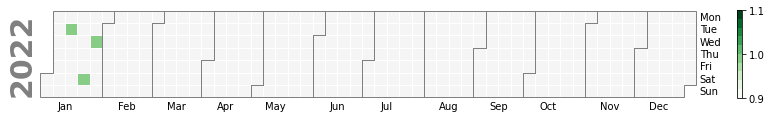

In [43]:
pipeline_plot_rounds_date_played_calendar(user_id)

### Making Basic Information
This section will contain the code required to get information showing total rounds/courses/countries played and average score

In [44]:
def make_sql_total_rounds_played(user_id):
    """
    Function queries the round table and returns the amount of rounds inputted/played by user
    :param user_id: id of user
    :return: rounds played
    """
    insert_command = """SELECT count(user_id)
                    FROM round
                    WHERE user_id=%s;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    rounds_played = returned_value[0][0]
    return rounds_played

In [45]:
make_sql_total_rounds_played(user_id)

3

In [46]:
def make_sql_total_courses_played(user_id):
    """
    Function queries the course table, joins with round and returns the amount of distinct courses a player has rounds for based on course_id
    :param user_id: id of user
    :return: courses played
    """
    insert_command = """SELECT count(DISTINCT name)
                        FROM (SELECT course.name
                            FROM course
                            INNER JOIN round on course.course_id = round.course_id
                            WHERE round.user_id=%s) as t_round_course;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    courses_played = returned_value[0][0]
    return courses_played

In [47]:
make_sql_total_courses_played(user_id)

3

In [48]:
def make_sql_total_countries_played(user_id):
    """
    Function queries the course table, joins with round and returns the amount of distinct countries a player has rounds for based on course_id
    :param user_id: id of user
    :return: courses played
    """
    insert_command = """SELECT count(DISTINCT country)
                        FROM (SELECT course.country
                                FROM course
                                INNER JOIN round on course.course_id = round.course_id
                                WHERE round.user_id=%s) as t_round_country;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    countries_played = returned_value[0][0]
    return countries_played

In [49]:
make_sql_total_countries_played(user_id)

2

In [50]:
def make_total_rounds_courses_countries(user_id):
    """
    Function pipelines the functions needed to return total rounds played, total distinct courses played and total distinct countries played
    :param user_id: id of user
    :return: rounds/courses/countries played
    """
    rounds_played = make_sql_total_rounds_played(user_id)
    courses_played = make_sql_total_courses_played(user_id)
    countries_played = make_sql_total_countries_played(user_id)
    return rounds_played, courses_played, countries_played

In [51]:
rounds_played, courses_played, countries_played = make_total_rounds_courses_countries(1)

In [52]:
ROUND_COURSE_COUNTRY_PLAYED_TEXT = "You've played {} rounds across {} golf courses in {} different countries."

def pipeline_make_total_rounds_courses_countries_text(user_id):
    """
    Function pipelines the functions needed to a text to show total rounds played, total distinct courses played and total distinct countries played
    :return: text show total rounds/courses/countries played
    """
    rounds_played, courses_played, countries_played = make_total_rounds_courses_countries(user_id)
    text = ROUND_COURSE_COUNTRY_PLAYED_TEXT.format(rounds_played, courses_played, countries_played)
    return text

In [53]:
pipeline_make_total_rounds_courses_countries_text(user_id)

"You've played 3 rounds across 3 golf courses in 2 different countries."

In [54]:
ROUND_COURSE_COUNTRY_PLAYED_TEXT = "You've played {} rounds across {} golf courses in {} different countries."

def make_sql_total_rounds_played(user_id):
    """
    Function queries the round table and returns the amount of rounds inputted/played by user
    :param user_id: id of user
    :return: rounds played
    """
    insert_command = """SELECT count(user_id)
                    FROM round
                    WHERE user_id=%s;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    rounds_played = returned_value[0][0]
    return rounds_played

def make_sql_total_courses_played(user_id):
    """
    Function queries the course table, joins with round and returns the amount of distinct courses a player has rounds for based on course_id
    :param user_id: id of user
    :return: courses played
    """
    insert_command = """SELECT count(DISTINCT name)
                        FROM (SELECT course.name
                            FROM course
                            INNER JOIN round on course.course_id = round.course_id
                            WHERE round.user_id=%s) as t_round_course;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    courses_played = returned_value[0][0]
    return courses_played

def make_sql_total_countries_played(user_id):
    """
    Function queries the course table, joins with round and returns the amount of distinct countries a player has rounds for based on course_id
    :param user_id: id of user
    :return: courses played
    """
    insert_command = """SELECT count(DISTINCT country)
                        FROM (SELECT course.country
                                FROM course
                                INNER JOIN round on course.course_id = round.course_id
                                WHERE round.user_id=%s) as t_round_country;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    countries_played = returned_value[0][0]
    return countries_played

def make_total_rounds_courses_countries(user_id):
    """
    Function pipelines the functions needed to return total rounds played, total distinct courses played and total distinct countries played
    :param user_id: id of user
    :return: rounds/courses/countries played
    """
    rounds_played = make_sql_total_rounds_played(user_id)
    courses_played = make_sql_total_courses_played(user_id)
    countries_played = make_sql_total_countries_played(user_id)
    return rounds_played, courses_played, countries_played

def pipeline_make_total_rounds_courses_countries_text(user_id):
    """
    Function pipelines the functions needed to a text to show total rounds played, total distinct courses played and total distinct countries played
    :return: text show total rounds/courses/countries played
    """
    rounds_played, courses_played, countries_played = make_total_rounds_courses_countries(user_id)
    text = ROUND_COURSE_COUNTRY_PLAYED_TEXT.format(rounds_played, courses_played, countries_played)
    return text

In [55]:
pipeline_make_total_rounds_courses_countries_text(user_id)

"You've played 3 rounds across 3 golf courses in 2 different countries."

### Average 18, Front/Back 9 Scores
This section will create the SQL queries needed to get average 18 and front/back9 scores for a specified user for all par 72 rounds played

In [66]:
def make_sql_par_72_round_18_hole_average(user_id):
    """
    Function returns the average 18 hole score for all rounds played by a user in par 72 courses
    :param user_id: id of user
    :return: average round 18 hole score
    """
    insert_command = """SELECT AVG(total) AS all_round_avg
                        FROM (
                            SELECT COALESCE(rs.hole1,0) + COALESCE(rs.hole2,0) + COALESCE(rs.hole3,0) + COALESCE(rs.hole4,0) +
                            COALESCE(rs.hole5,0) + COALESCE(rs.hole6,0) + COALESCE(rs.hole7,0) + COALESCE(rs.hole8,0) +
                            COALESCE(rs.hole9,0) + COALESCE(rs.hole10,0) + COALESCE(rs.hole11,0) + COALESCE(rs.hole12,0) +
                            COALESCE(rs.hole13,0) + COALESCE(rs.hole14,0) + COALESCE(rs.hole15,0) + COALESCE(rs.hole16,0) +
                            COALESCE(rs.hole17,0) + COALESCE(rs.hole18,0) AS total
                            FROM course
                            JOIN round ON course.course_id = round.course_id
                            JOIN round_shots rs on round.round_id = rs.round_id
                            WHERE course.par=72
                            AND round.user_id=%s)
                        AS t;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    avg_round_score = round(returned_value[0][0])
    return avg_round_score

In [67]:
make_sql_par_72_round_18_hole_average(21)

108

In [68]:
def make_sql_par_72_round_front9_average(user_id):
    """
    Function returns the average front9 hole score for all rounds played by a user in par 72 courses
    :param user_id: id of user
    :return: average round front9 hole score
    """
    insert_command = """SELECT AVG(total) AS all_round_avg
                        FROM (
                            SELECT COALESCE(rs.hole1,0) + COALESCE(rs.hole2,0) + COALESCE(rs.hole3,0) +
                                   COALESCE(rs.hole4,0) +COALESCE(rs.hole5,0) + COALESCE(rs.hole6,0) + COALESCE(rs.hole7,0) + COALESCE(rs.hole8,0) +
                                   COALESCE(rs.hole9,0) AS total
                            FROM course
                            JOIN round ON course.course_id = round.course_id
                            JOIN round_shots rs on round.round_id = rs.round_id
                            WHERE course.par=72
                            AND round.user_id=%s)
                        AS t;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    avg_round_score = round(returned_value[0][0])
    return avg_round_score

In [69]:
make_sql_par_72_round_front9_average(user_id)

53

In [70]:
def make_sql_par_72_round_back9_average(user_id):
    """
    Function returns the average back9 hole score for all rounds played by a user in par 72 courses
    :param user_id: id of user
    :return: average round back9 hole score
    """
    insert_command = """SELECT AVG(total) AS all_round_avg
                        FROM (
                            SELECT COALESCE(rs.hole10,0) + COALESCE(rs.hole11,0) + COALESCE(rs.hole12,0) + COALESCE(rs.hole13,0) +
                                   COALESCE(rs.hole14,0) + COALESCE(rs.hole15,0) + COALESCE(rs.hole16,0) + COALESCE(rs.hole17,0) +
                                   COALESCE(rs.hole18,0) AS total
                            FROM course
                            JOIN round ON course.course_id = round.course_id
                            JOIN round_shots rs on round.round_id = rs.round_id
                            WHERE course.par=72
                            AND round.user_id=%s)
                        AS t;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    avg_round_score = round(returned_value[0][0])
    return avg_round_score

In [71]:
make_sql_par_72_round_back9_average(user_id)

55

In [77]:
BETTER_FRONT9_TEXT = "You get off to a hot start!"
BETTER_BACK9_TEXT = "You are able to finish your round well!"
SAME_FRONT_BACK9_TEXT = "You are consistent throughout your round!"
ROUND_AVERAGE_SCORE_TEXT = "For par 72 courses, your average 18 hole score is {}. From these rounds, your average front 9 score is {} and your back 9 score is {}. {}"


def make_sql_par_72_round_18_hole_average(user_id):
    """
    Function returns the average 18 hole score for all rounds played by a user in par 72 courses
    :param user_id: id of user
    :return: average round 18 hole score
    """
    insert_command = """SELECT AVG(total) AS all_round_avg
                        FROM (
                            SELECT COALESCE(rs.hole1,0) + COALESCE(rs.hole2,0) + COALESCE(rs.hole3,0) + COALESCE(rs.hole4,0) +
                            COALESCE(rs.hole5,0) + COALESCE(rs.hole6,0) + COALESCE(rs.hole7,0) + COALESCE(rs.hole8,0) +
                            COALESCE(rs.hole9,0) + COALESCE(rs.hole10,0) + COALESCE(rs.hole11,0) + COALESCE(rs.hole12,0) +
                            COALESCE(rs.hole13,0) + COALESCE(rs.hole14,0) + COALESCE(rs.hole15,0) + COALESCE(rs.hole16,0) +
                            COALESCE(rs.hole17,0) + COALESCE(rs.hole18,0) AS total
                            FROM course
                            JOIN round ON course.course_id = round.course_id
                            JOIN round_shots rs on round.round_id = rs.round_id
                            WHERE course.par=72
                            AND round.user_id=%s)
                        AS t;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    avg_round_score = round(returned_value[0][0])
    return avg_round_score


def make_sql_par_72_round_front9_average(user_id):
    """
    Function returns the average front9 hole score for all rounds played by a user in par 72 courses
    :param user_id: id of user
    :return: average round front9 hole score
    """
    insert_command = """SELECT AVG(total) AS all_round_avg
                        FROM (
                            SELECT COALESCE(rs.hole1,0) + COALESCE(rs.hole2,0) + COALESCE(rs.hole3,0) +
                                   COALESCE(rs.hole4,0) +COALESCE(rs.hole5,0) + COALESCE(rs.hole6,0) + COALESCE(rs.hole7,0) + COALESCE(rs.hole8,0) +
                                   COALESCE(rs.hole9,0) AS total
                            FROM course
                            JOIN round ON course.course_id = round.course_id
                            JOIN round_shots rs on round.round_id = rs.round_id
                            WHERE course.par=72
                            AND round.user_id=%s)
                        AS t;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    avg_round_score = round(returned_value[0][0])
    return avg_round_score


def make_sql_par_72_round_back9_average(user_id):
    """
    Function returns the average back9 hole score for all rounds played by a user in par 72 courses
    :param user_id: id of user
    :return: average round back9 hole score
    """
    insert_command = """SELECT AVG(total) AS all_round_avg
                        FROM (
                            SELECT COALESCE(rs.hole10,0) + COALESCE(rs.hole11,0) + COALESCE(rs.hole12,0) + COALESCE(rs.hole13,0) +
                                   COALESCE(rs.hole14,0) + COALESCE(rs.hole15,0) + COALESCE(rs.hole16,0) + COALESCE(rs.hole17,0) +
                                   COALESCE(rs.hole18,0) AS total
                            FROM course
                            JOIN round ON course.course_id = round.course_id
                            JOIN round_shots rs on round.round_id = rs.round_id
                            WHERE course.par=72
                            AND round.user_id=%s)
                        AS t;"""
    cursor.execute(insert_command, [user_id])
    returned_value = cursor.fetchall()
    avg_round_score = round(returned_value[0][0])
    return avg_round_score


def make_par_72_18_front_back_9_averages(user_id):
    """
    Function pipelines the functions needed to return average 18 and front/back9 hole score
    :param user_id: id of user
    :return: average 18 and front/back9 hole score
    """
    avg_18_hole_round_score = make_sql_par_72_round_18_hole_average(user_id)
    avg_front9_hole_round_score = make_sql_par_72_round_front9_average(user_id)
    avg_back9_hole_round_score = make_sql_par_72_round_back9_average(user_id)
    return avg_18_hole_round_score, avg_front9_hole_round_score, avg_back9_hole_round_score


def make_front_back_9_comparison_text(avg_front9, avg_back9):
    """
    Function returns a text based on a players average front/back9 score
    :param avg_front9: average strokes on the front9
    :param avg_back9: average strokes on the back9
    :return: comparison text
    """
    if avg_front9 < avg_back9:
        return BETTER_FRONT9_TEXT
    elif avg_front9 > avg_back9:
        return BETTER_BACK9_TEXT
    elif avg_front9 == avg_back9:
        return SAME_FRONT_BACK9_TEXT


def pipeline_make_average_round_score_text(user_id):
    """
    Function pipelines the functions needed to a text to show total rounds played, total distinct courses played and total distinct countries played
    :return: text show total rounds/courses/countries played
    """
    avg_18_hole_round_score, avg_front9_hole_round_score, avg_back9_hole_round_score = make_par_72_18_front_back_9_averages(user_id)
    comparison_text = make_front_back_9_comparison_text(avg_front9_hole_round_score, avg_back9_hole_round_score)
    text = ROUND_AVERAGE_SCORE_TEXT.format(avg_18_hole_round_score, avg_front9_hole_round_score, avg_back9_hole_round_score, comparison_text)
    return text

In [78]:
pipeline_make_average_round_score_text(user_id)

'For par 72 courses, your average 18 hole score is 108. From these rounds, your average front 9 score is 53 and your back 9 score is 55. You get off to a hot start!'